In [1]:
# Create an agent which navigates and solves the environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# Initialize the environment

In [2]:
PATH_TO_ENV = "Banana_Linux/Banana.x86"
BRAIN = "BananaBrain"
TRAINING = True

env = UnityEnvironment(file_name=PATH_TO_ENV, no_graphics=TRAINING)
bananator = env.brains[BRAIN]

# number of actions
ACTION_SIZE = bananator.vector_action_space_size

# reset the environment
env_info = env.reset(train_mode=TRAINING)[BRAIN]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# examine the state space 
state = env_info.vector_observations[0]
STATE_SIZE = len(state)

print('States look like:')
print(state)
print()
print(type(state))

States look like:
[1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]

<class 'numpy.ndarray'>


# Convenience functions

In [4]:
def act(env, action, brain_name=BRAIN) -> tuple:
    """Lets brain_name perform action on the environment env.
    Returns a tuple of reward, next_state, done"""
    action_result = env.step(action)[brain_name] # Act on the environment and observe the result
    return (action_result.rewards[0], # reward from action
            action_result.vector_observations[0], # next state
            action_result.local_done[0]) # True if the episode ended
    
def reset(env, training=TRAINING, brain_name=BRAIN) -> tuple:
    """Syntactic sugar for resetting the unity environment"""
    return env.reset(train_mode=training)[brain_name].vector_observations[0] 

# Prepare the training

In [5]:
# Invite our agent & import utils
from dqn_agent import Agent, Parameters
import torch

In [6]:
# Profiling (optional)
import cProfile
profiling = False # Set to True to profile execution time
if profiling:
    profile = cProfile.Profile()

In [7]:
# Define training steps
def train(agent, env, num_episodes, log_freq, profiling=False, profile=None):
        
    score_hist = []
    # Define epsilon power-law decay
    decay_power = -2
    eps_max = 1
    eps_min = .1 ** (1/decay_power)
    eps_end = round(num_episodes * .5)
    epsilon = np.full(num_episodes, eps_min)
    epsilon[:eps_end] = np.linspace(eps_max, eps_min, eps_end)
    epsilon = epsilon ** decay_power
    
    if profiling: 
        profile.enable()
        
    # Train
    for i in range(num_episodes):
        state = reset(env)
        score = 0
        done = False
        j = 0
        while not done:
            j += 1
            action, expectation = agent.decide(state, epsilon[i])  # Choose an action based on the state
            reward, next_state, done = act(env, action)    # Send the action to the environment
            agent.step(state, action, reward, expectation, next_state, done) # Learn step
            score += reward                                # Update the score
            state = next_state                             # Roll over the state to next time step
            if j >= 1e5:
                # Stop this madness -- just in case
                done = True

        # Logging
        score_hist.append(score)
        if (i % log_freq == 0) and (i > 0):
            print(f'Avg. score episodes {i-log_freq+1}-{i+1}: {np.mean(score_hist[-log_freq:])}')

    if profiling: 
        profile.disable()

    print("Score: {}".format(score))
    
    return np.array(score_hist)

# Vanilla run

In [11]:
# Reference to the parameters used in Prioritized Experience Replay (PER):
# [1] https://danieltakeshi.github.io/2019/07/14/per/
# [2] https://arxiv.org/pdf/1511.05952.pdf

In [21]:
params_vanilla = Parameters(buffer_size = int(1e5),  # replay buffer size
                            batch_size = 64,         # minibatch size
                            gamma = 0.99,            # discount factor
                            tau = 1e-3,              # for soft update of target parameters
                            lr = 5e-4,               # learning rate 
                            update_every = 4,        # how often to update the network
                            state_size = STATE_SIZE,
                            action_size = ACTION_SIZE,
                            use_per = False,          # Activate Prioritized Experience Replay?
                            per_min_priority = .05,  # "Epsilon" in [2]
                            per_prio_coeff = 1,      # "Alpha" in [2]
                            per_w_bias_coeff = 1,    # "Beta" in [2]
                            seed = np.random.randint(1000))

bananator_vanilla = Agent(params_vanilla, cuda=False)

In [22]:
%%time
scores_vanilla = train(bananator_vanilla, env, num_episodes = 1000, log_freq=200)

Avg. score episodes 1-201: 3.945
Avg. score episodes 201-401: 10.18
Avg. score episodes 401-601: 12.655
Avg. score episodes 601-801: 13.91
Score: 11.0
CPU times: user 2h 41min 33s, sys: 2h 18min 15s, total: 4h 59min 49s
Wall time: 29min 14s


# Prioritized Experience Replay run

In [8]:
params_per = Parameters(buffer_size = int(1e5),  # replay buffer size
                        batch_size = 64,         # minibatch size
                        gamma = 0.99,            # discount factor
                        tau = 1e-3,              # for soft update of target parameters
                        lr = 5e-4,               # learning rate 
                        update_every = 4,        # how often to update the network
                        state_size = STATE_SIZE,
                        action_size = ACTION_SIZE,
                        use_per = True,          # Activate Prioritized Experience Replay?
                        per_min_priority = .05,  # "Epsilon" in [2]
                        per_prio_coeff = .7,      # "Alpha" in [2]
                        per_w_bias_coeff = .7,    # "Beta" in [2]
                        seed = np.random.randint(1000))

bananator_per = Agent(params_per, cuda=False)

In [9]:
%%time
scores_per = train(bananator_per, env, num_episodes = 800, log_freq=200)

Avg. score episodes 1-201: 2.52
Avg. score episodes 201-401: 8.15
Avg. score episodes 401-601: 11.53
Score: 11.0
CPU times: user 3h 28min 48s, sys: 2h 44min 24s, total: 6h 13min 12s
Wall time: 34min 55s


In [16]:
env.close()

# Plotting + visualizing

In [23]:
from matplotlib import pyplot as plt
#import seaborn as sns

In [24]:
def moving_average(signal:np.ndarray , period: int):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return np.array(buffer)

#def moving_std(signal:np.ndarray , period: int):
#    buffer = [np.nan] * period
#    for i in range(period,len(signal)):
#        buffer.append(signal[i-period:i].std())
#    return np.array(buffer)

(0, 1400)

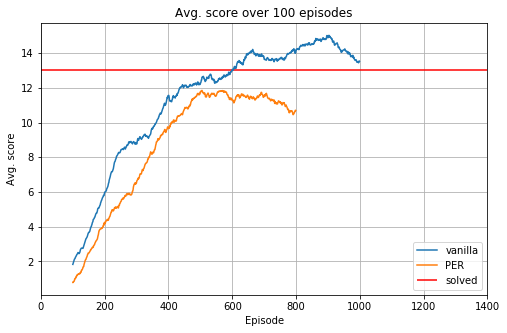

In [26]:
length = 100
avg_scores_vanilla = moving_average(scores_vanilla, length,)
avg_scores_per = moving_average(scores_per, length)
plt.figure(figsize=(8,5))
plt.plot(avg_scores_vanilla, label='vanilla')
plt.plot(avg_scores_per, label='PER')
plt.hlines(13, xmin=0, xmax=1500, colors='r', label='solved')
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Avg. score')
plt.title(f'Avg. score over {length} episodes')
plt.legend(loc='lower right')
plt.xlim((0, 1400))

# Save models

In [27]:
def save_agent(agent, name, params):
    """Saves the agent's parameters and the underlying pytorch model"""
    checkpoint = {'state_dict': agent.qnetwork_local.state_dict(),
                  'agent_params': params}
    torch.save(checkpoint, f'models/{name}-checkpoint.pth')

In [28]:
save_agent(bananator_vanilla, 'vanilla', params_vanilla)
save_agent(bananator_per, 'per', params_per)